In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
from torch import optim
from torch import nn
from torch import distributions as dist
from enum import Enum

In [11]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
from torch import optim
from torch import nn
from torch import distributions as dist
from enum import Enum

# boolean variable that indicates whether or not we have gpu...
use_cuda = torch.cuda.is_available()
print("Use GPU: {}".format(use_cuda))

# Default gaussian mixture parameters
PI = 0.5

SIGMA_1 = torch.tensor([math.exp(-0)])
SIGMA_2 = torch.tensor([math.exp(-6)])

# place tensor in GPU if use_cuda
if use_cuda:
  SIGMA_1 = SIGMA_1.cuda()
  SIGMA_2 = SIGMA_2.cuda()

# Default gaussian parameters
MU_PRIOR = 0
SIGMA_PRIOR = torch.tensor([math.exp(-0)])

# place tensor in GPU if use_cuda
if use_cuda:
    SIGMA_PRIOR = SIGMA_PRIOR.cuda()

# Initial weight hyperparameters
MU_WEIGHTS = (-0.03, 0.03)
RHO_WEIGHTS = (-4.31, -4.30)
MU_BIAS = (-0.03, 0.03)
RHO_BIAS = (-4.31, -4.30)

# Loss variance for regression
SIGMA = torch.tensor([math.exp(-1)])

# place tensor in GPU if use_cuda
if use_cuda:
    SIGMA = SIGMA.cuda()

class PriorType(Enum):
  MIXTURE = 1
  GAUSSIAN = 2

class ActivationType(Enum):
  NONE = 0
  RELU = 1
  SOFTMAX = 2
  TANH = 3
  SIGMOID = 4

class TaskType(Enum):
  REGRESSION = 1
  CLASSIFICATION = 2

class GaussianMixture(object):

  def __init__(self, pi, sigma1, sigma2):
    self.pi = pi
    self.sigma1 = sigma1
    self.sigma2 = sigma2

  # arguments of dist.Normal() should be tensors rather than scalars
  def log_prob(self, weights):
    new_weights = weights.view(-1)
    normal_density1 = dist.Normal(0,self.sigma1).log_prob(new_weights)
    exp_normal_density1 = torch.exp(normal_density1)
    exp_normal_density2 = torch.exp(
        dist.Normal(0.0, self.sigma2).log_prob(new_weights))
    nonzero = exp_normal_density2.nonzero()
    zero = (exp_normal_density2==0).nonzero()
    sum_log_prob = torch.sum(torch.log(self.pi * torch.take(exp_normal_density1,nonzero) \
                  + (1-self.pi)*torch.take(exp_normal_density2,nonzero))) \
                  + torch.sum(torch.take(normal_density1, zero)+np.log(self.pi))
    return sum_log_prob

class BayesianLayer(nn.Module):

  def __init__(self,
               input_size,
               output_size,
               prior_type=PriorType.MIXTURE,
               prior_params={'pi' : PI, 'sigma1' : SIGMA_1, 'sigma2' : SIGMA_2},
               activation_type=ActivationType.NONE,
              ):
    super().__init__()
    self.input_size = input_size
    self.output_size = output_size
    self.activation_type = activation_type

    # create torch variables
    if not use_cuda:
        self.mu_weights = nn.Parameter(torch.Tensor(output_size, input_size))
        self.rho_weights = nn.Parameter(torch.Tensor(output_size, input_size))
        self.mu_bias = nn.Parameter(torch.Tensor(output_size))
        self.rho_bias = nn.Parameter(torch.Tensor(output_size))
        self.normal_dist = dist.Normal(torch.Tensor([0]), torch.Tensor([1]))
    else:
        self.mu_weights = nn.Parameter(torch.Tensor(output_size, input_size).cuda())
        self.rho_weights = nn.Parameter(torch.Tensor(output_size, input_size).cuda())
        self.mu_bias = nn.Parameter(torch.Tensor(output_size).cuda())
        self.rho_bias = nn.Parameter(torch.Tensor(output_size).cuda())
        self.normal_dist = dist.Normal(torch.Tensor([0]).cuda(), torch.Tensor([1]).cuda())

    # initialize variables
    self.mu_weights.data.uniform_(*MU_WEIGHTS)
    self.rho_weights.data.uniform_(*RHO_WEIGHTS)
    self.mu_bias.data.uniform_(*MU_BIAS)
    self.rho_bias.data.uniform_(*RHO_BIAS)

    if prior_type == PriorType.MIXTURE:
      self.prior_weights = GaussianMixture(
          prior_params['pi'], prior_params['sigma1'], prior_params['sigma2'])
      self.prior_bias = GaussianMixture(
          prior_params['pi'], prior_params['sigma1'], prior_params['sigma2'])
    else:
      self.prior_weights = dist.Normal(prior_params['mean'],
                                       prior_params['sigma'])
      self.prior_bias = dist.Normal(prior_params['mean'],
                                    prior_params['sigma'])
    self.log_prior = 0
    self.log_posterior = 0

  def _compute_gaussian_sample(self, mu, rho):
    epsilon = self.normal_dist.sample(rho.size()).squeeze(-1)
    return mu + torch.log2(1 + torch.exp(rho)) * epsilon

  def forward(self, input_data, sample=False, debug=False):
    if self.training or sample:
      weights = self._compute_gaussian_sample(self.mu_weights, self.rho_weights)
      bias = self._compute_gaussian_sample(self.mu_bias, self.rho_bias)
      if debug is True:
        print("sampled weights:")
        print(weights)
      self.log_prior = (self.prior_weights.log_prob(weights).sum() +
                        self.prior_bias.log_prob(bias).sum() )
      sigma_weights = torch.log(1 + torch.exp(self.rho_weights))
      sigma_bias = torch.log(1 + torch.exp(self.rho_bias))
      self.log_posterior = (
          dist.Normal(
              self.mu_weights, sigma_weights).log_prob(weights).sum() +
          dist.Normal(self.mu_bias, sigma_bias).log_prob(bias).sum()
      )

      if torch.isnan(self.log_posterior):
        print('Weights log prob: ')
        print( dist.Normal(
              self.mu_weights, sigma_weights).log_prob(weights).sum())
        print('Bias log prob: ' )
        print(dist.Normal(self.mu_bias, sigma_bias).log_prob(bias).sum())
    else:
      weights = self.mu_weights
      bias = self.mu_bias

    linear_output = nn.functional.linear(input_data, weights, bias)
    output = linear_output
    if self.activation_type == ActivationType.RELU:
      output = torch.relu(linear_output)
    elif self.activation_type == ActivationType.SOFTMAX:
      output = torch.log_softmax(linear_output, dim=1)
    elif self.activation_type == ActivationType.SIGMOID:
      output = torch.sigmoid(linear_output)
    elif self.activation_type == ActivationType.TANH:
      output = torch.tanh(linear_output)
    elif self.activation_type == ActivationType.NONE:
      output = linear_output
    else:
      raise ValueError('activation_type {} not support'.format(self.activation_type))
    return output

  def extra_repr(self):
    return 'Bayesian Layer, in_size:{}, out_size:{}, activation_type:{}'.format(
      self.input_size, self.output_size, self.activation_type.name
    )

class BayesianNN(nn.Module):

  def __init__(
      self,
      nn_input_size,
      layer_config=[100, 100, 10],           # list of layer output sizes
      activation_config=[ActivationType.RELU, ActivationType.RELU, ActivationType.NONE],
      prior_type=PriorType.MIXTURE,
      prior_params={'pi' : PI, 'sigma1' : SIGMA_1, 'sigma2' : SIGMA_2},
      task_type=TaskType.REGRESSION,         # determines the likelihood form
  ):
    super().__init__()

    self.layers = nn.ModuleList([]) # ensures that all params are registered
    self.input_size = nn_input_size
    for i, output_size in enumerate(layer_config):
      if i == 0:
        input_size = self.input_size
      else:
        input_size = layer_config[i-1]

      bayesian_layer = BayesianLayer(input_size, output_size,
                                     activation_type = activation_config[i],
                                     prior_type=prior_type,
                                     prior_params=prior_params)
      self.layers.append(bayesian_layer)
    self.output_size = self.layers[-1].output_size
    self.task_type = task_type

  def forward(self, input_data, sample=True, debug=False):
    current_data = input_data
    for layer in self.layers:
      current_data = layer.forward(current_data, sample, debug=debug)
    if sample is False:
        print("not sampling.")
    return current_data

  # sample a bunch of weights for the network
  # make predictions using sampled weights
  # output averaged predictions from different sampled weights
  def predict_by_sampling(self, input_data, num_samples=1):
    # reduce the use of memory
    with torch.no_grad():
        outputs = torch.empty(num_samples, input_data.size()[0], self.output_size)
        for i in range(num_samples):
            print("*"*20)
            outputs[i] = self.forward(input_data, sample=True, debug=True)
            print(outputs[i][0])
            print("*"*20)
        stds = outputs.std(0)
        print("std in probability distributions:", stds.mean(0))
        outputs = outputs.mean(0)
    return outputs

  def log_prior(self):
    log_prior = 0
    for layer in self.layers:
      log_prior += layer.log_prior
    return log_prior

  def log_posterior(self):
    log_posterior = 0
    for layer in self.layers:
      log_posterior += layer.log_posterior
    return log_posterior

  def cost_function(self, inputs, targets, num_samples, ratio):
    sum_log_posterior = 0
    sum_log_prior = 0
    sum_negative_log_likelihood = 0
    for n in range(num_samples):
      outputs = self(inputs, sample=True)
      sum_log_posterior += self.log_posterior()
      sum_log_prior += self.log_prior()
      if self.task_type == TaskType.CLASSIFICATION:
         # the outputs are from log_softmax activation function
         log_probs = outputs[range(targets.size()[0]), targets]
         # the negative sum of log probs is the negative log likelihood
         # for this sampled neural network on this minibatch
         negative_log_likelihood = -log_probs.sum()
         # negative_log_likelihood = nn.functional.nll_loss(outputs, targets)
      elif self.task_type == TaskType.REGRESSION:
         negative_log_likelihood = - dist.Normal(
             targets, SIGMA).log_prob(outputs).sum()
      sum_negative_log_likelihood += negative_log_likelihood
    kl_divergence = (sum_log_posterior / num_samples - sum_log_prior / num_samples) * ratio
    negative_log_likelihood = sum_negative_log_likelihood / num_samples
    loss =  kl_divergence + negative_log_likelihood
    return loss, kl_divergence, negative_log_likelihood

  def extra_repr(self):
    repr = ''
    for layer in self.layers:
      repr += layer.extra_repr()
      repr += '\n'
    return repr

Use GPU: True


In [0]:
net = BayesianNN(
    nn_input_size=1, 
    layer_config=[100, 100, 1], 
    activation_config=[ActivationType.RELU, ActivationType.RELU, ActivationType.NONE], 
    prior_type=PriorType.GAUSSIAN,
    prior_params={'mean': 0, 'sigma': 10},
    task_type=TaskType.REGRESSION)
if use_cuda:
    net = net.cuda()

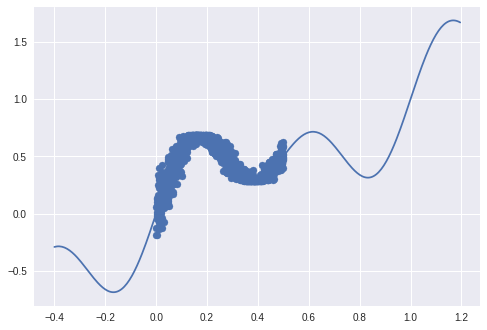

In [29]:
# Regression curves data

SAMPLE_SIZE = 1200

def noisy_function(x):
  epsilon = dist.Normal(0, 0.02).sample(torch.Size([SAMPLE_SIZE]))
  return (x + 0.3 * torch.sin(2 * math.pi * (x + epsilon)) +
          0.3 * torch.sin(4 * math.pi * (x + epsilon)) + epsilon)

def true_function(x):
  return x + 0.3 * torch.sin(2 * math.pi * x) + 0.3 * torch.sin(4 * math.pi * x)
 
trainfeatures = dist.Uniform(
    torch.tensor([0.0]), torch.tensor([0.5])).sample(torch.Size([SAMPLE_SIZE])).flatten()
trainlabels = noisy_function(trainfeatures) 

true_range = torch.arange(-0.4, 1.2, 0.005)
true_labels = true_function(true_range)

if use_cuda:
  true_range = true_range.cuda()

plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy())
plt.plot(true_range.cpu().numpy(), true_labels.flatten().cpu().numpy())
plt.plot()

trainfeatures = trainfeatures.view([SAMPLE_SIZE, 1])
trainlabels = trainlabels.view([SAMPLE_SIZE, 1])
trainset = torch.utils.data.TensorDataset(trainfeatures, trainlabels)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=120,
                                          shuffle=True, num_workers=2)

loss: tensor(3947.3184, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3950.9009, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.5824, device='cuda:0', grad_fn=<DivBackward0>)


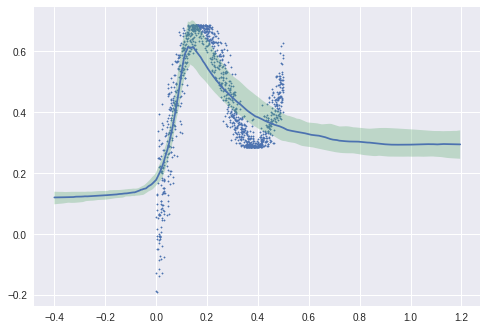

loss: tensor(3919.8877, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3919.8618, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.0259, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3888.9387, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3889.8044, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.8658, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3867.8743, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3870.0291, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.1548, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3830.0710, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3832.7312, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.6602, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3801.0356, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3804.4946, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.4591, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3757.0010, device='cuda:0', grad_fn=<A

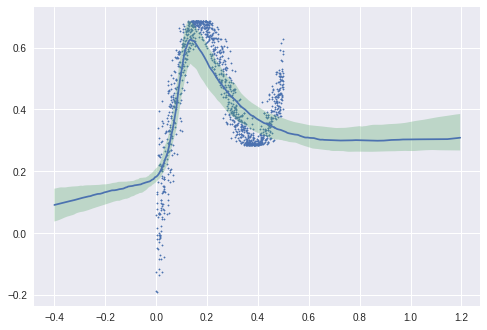

loss: tensor(3627.2336, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3629.2571, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.0233, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3601.1167, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3604.0708, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.9540, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3565.2898, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3569.2629, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.9730, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3542.8015, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3542.0369, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.7648, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3504.3679, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3507.1821, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.8143, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3478.0415, device='cuda:0', grad_fn=<A

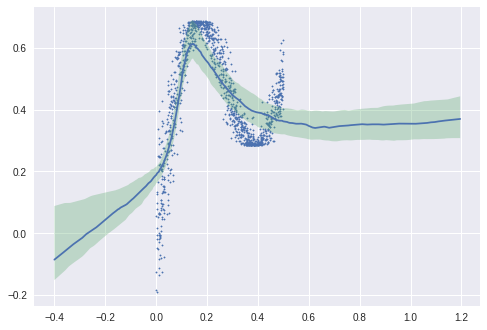

loss: tensor(3342.5847, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3345.1536, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.5688, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3315.4688, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3319.5059, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.0370, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3284.1367, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3285.9902, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.8536, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3254.1738, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3254.7839, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.6101, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3239.1418, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3240.3601, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.2183, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3202.1016, device='cuda:0', grad_fn=<

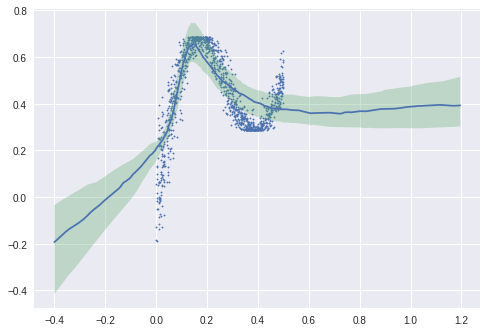

loss: tensor(3077.1758, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3079.4124, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.2365, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3050.4197, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3049.4744, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.9453, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(3018.4573, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(3018.5249, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.0676, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2992.9177, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2996.0945, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.1767, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2966.1833, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2968.4358, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.2524, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2941.5708, device='cuda:0', grad_fn=<A

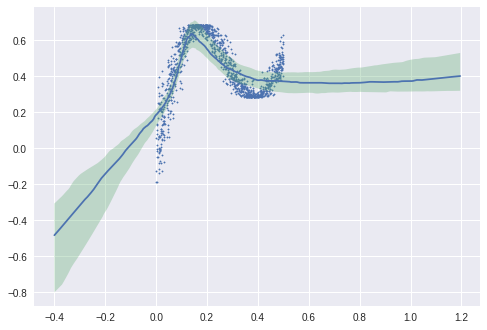

loss: tensor(2809.8611, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2810.4375, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.5763, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2779.7107, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2782.4878, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.7771, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2756.9924, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2758.7646, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.7722, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2727.6492, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2727.7253, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.0761, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2710.1104, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2710.3777, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.2674, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2685.5039, device='cuda:0', grad_fn=<

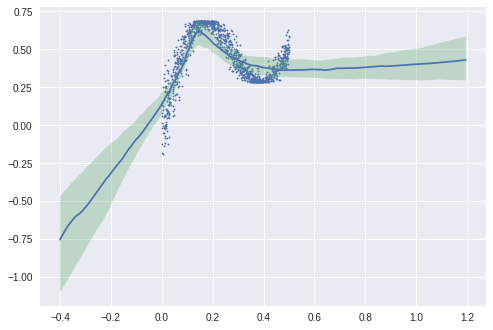

loss: tensor(2556.8645, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2560.0093, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.1447, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2538.8474, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2542.7371, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.8898, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2513.7417, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2513.6694, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.0722, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2489.3677, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2491.9465, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.5789, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2473.6150, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2473.4548, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.1600, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2439.2659, device='cuda:0', grad_fn=<Ad

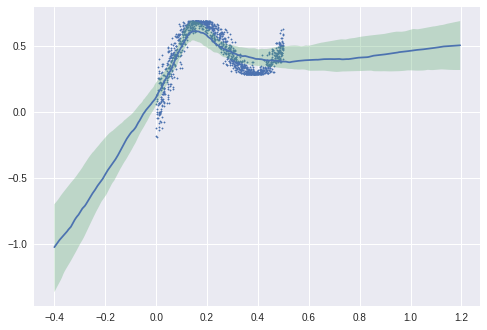

loss: tensor(2322.8140, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2326.8494, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.0353, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2306.7759, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2307.3123, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.5364, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2285.3726, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2288.1794, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.8069, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2266.1597, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2269.8794, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.7198, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2241.7505, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2242.6560, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.9055, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2222.0845, device='cuda:0', grad_fn=<

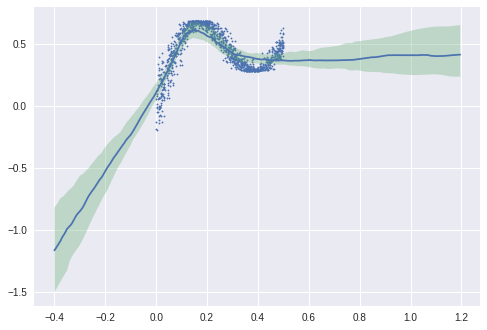

loss: tensor(2120.2688, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2121.7488, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.4799, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2090.9268, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2092.8018, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.8751, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2068.8606, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2069.8267, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.9661, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2062.0090, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2061.9734, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.0357, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2026.3207, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(2026.1016, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.2192, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(2013.1356, device='cuda:0', grad_fn=<Ad

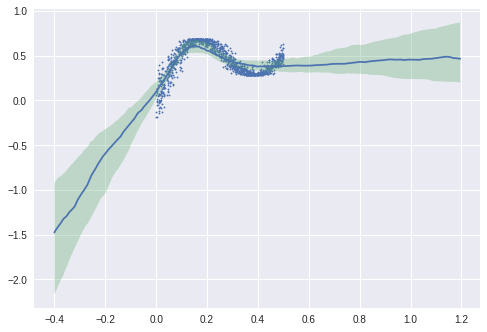

loss: tensor(1913.5580, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1918.3411, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.7830, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1893.9994, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1897.8383, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.8388, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1872.4697, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1876.0422, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.5725, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1854.7045, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1857.4554, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.7510, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1839.5043, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1842.8522, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.3479, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1821.2870, device='cuda:0', grad_fn=<

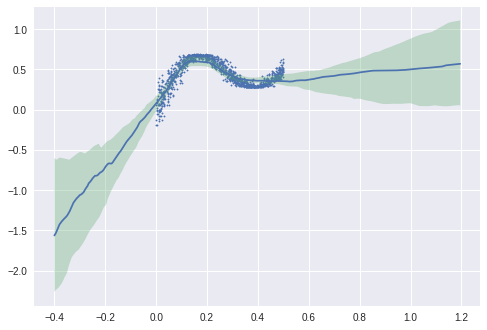

loss: tensor(1723.8577, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1725.2969, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.4392, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1712.9160, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1713.4143, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.4983, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1691.0876, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1693.8895, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.8019, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1682.2876, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1685.9912, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.7036, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1665.5203, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1668.8668, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.3466, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1644.7942, device='cuda:0', grad_fn=<

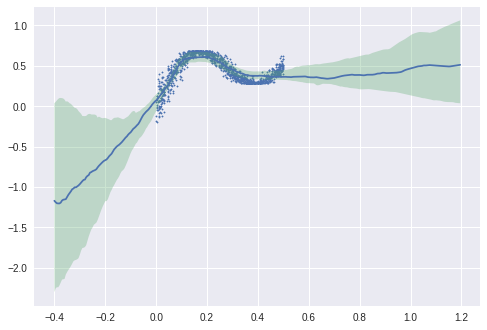

loss: tensor(1559.8206, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1561.7688, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.9483, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1552.3193, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1557.7092, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.3898, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1524.0521, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1529.3160, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.2639, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1514.4933, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1517.6119, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.1186, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1505.2313, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1510.1748, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.9434, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1474.3545, device='cuda:0', grad_fn=<

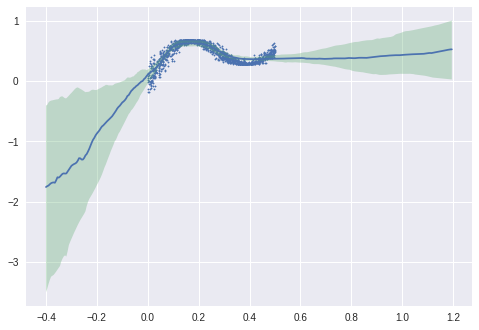

loss: tensor(1419.5634, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1423.0364, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.4730, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1407.5420, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1408.2601, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.7181, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1385.3153, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1386.7819, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.4665, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1371.0929, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1374.7141, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.6212, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1368.3134, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1371.5709, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.2576, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1343.3335, device='cuda:0', grad_fn=<

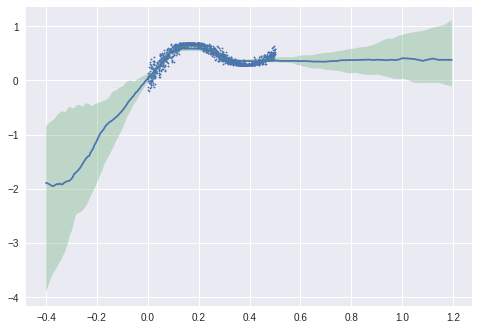

loss: tensor(1286.8666, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1288.0276, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.1610, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1277.4817, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1281.1318, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.6501, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1255.0618, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1255.1318, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.0701, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1243.8939, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1246.6223, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.7284, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1236.1785, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1240.1504, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.9719, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1221.0304, device='cuda:0', grad_fn=<

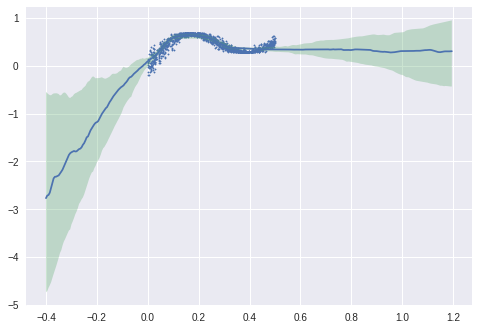

loss: tensor(1144.8643, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1147.0803, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.2161, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1144.4509, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1146.8014, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.3504, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1139.6682, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1144.3778, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.7097, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1116.6294, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1121.2030, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.5737, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1117.8351, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1117.5905, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(0.2446, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1092.7209, device='cuda:0', grad_fn=<A

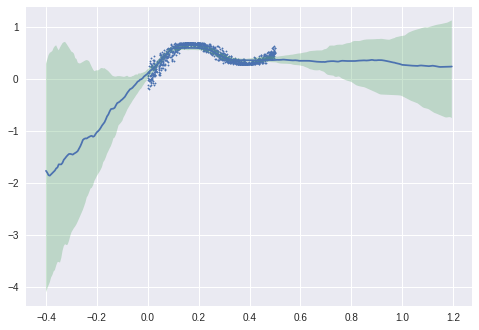

loss: tensor(1045.2031, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1047.6799, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.4768, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1043.4349, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1046.5762, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.1412, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1028.7258, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1031.7401, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.0142, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1018.6124, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1022.1891, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.5766, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(1006.1686, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(1008.8159, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.6473, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(998.9932, device='cuda:0', grad_fn=<A

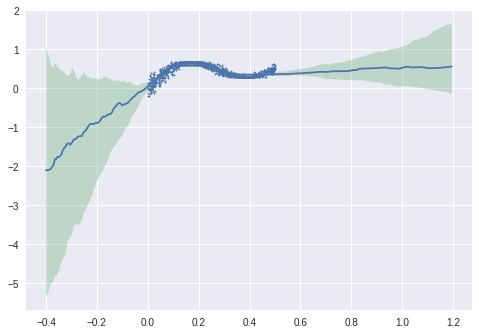

loss: tensor(960.2407, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(961.8735, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.6328, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(939.5934, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(944.9830, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.3896, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(929.4142, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(934.0885, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.6742, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(928.3738, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(932.5493, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.1755, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(924.4781, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(920.5447, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(3.9334, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(912.6746, device='cuda:0', grad_fn=<AddBackward0

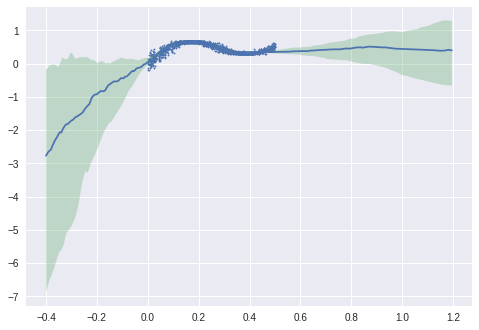

loss: tensor(898.8923, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(863.4283, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(35.4639, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(857.7433, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(862.0412, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.2979, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(841.0552, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(842.9049, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.8497, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(844.1061, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(842.7270, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(1.3791, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(828.0786, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(832.2941, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.2155, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(821.5824, device='cuda:0', grad_fn=<AddBackward0

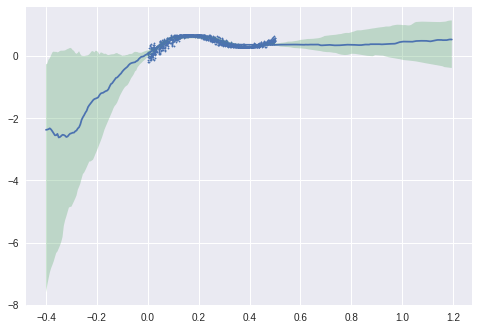

loss: tensor(783.5350, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(788.4545, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.9195, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(783.5528, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(784.5945, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.0418, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(764.5188, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(767.8651, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.3462, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(762.4855, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(767.2455, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.7601, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(759.1976, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(764.3149, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.1173, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(751.5231, device='cuda:0', grad_fn=<AddBackward

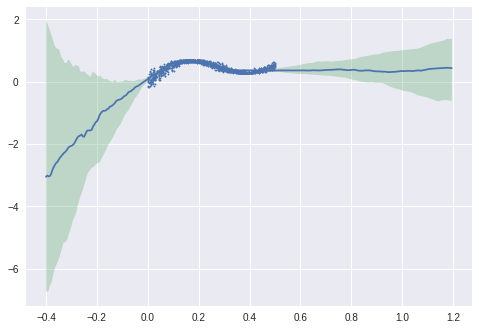

loss: tensor(716.2616, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(719.4404, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.1788, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(708.4945, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(713.1909, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.6963, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(697.7157, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(701.2648, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.5492, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(693.3239, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(697.3488, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.0249, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(684.3965, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(689.0055, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.6090, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(676.0256, device='cuda:0', grad_fn=<AddBackward

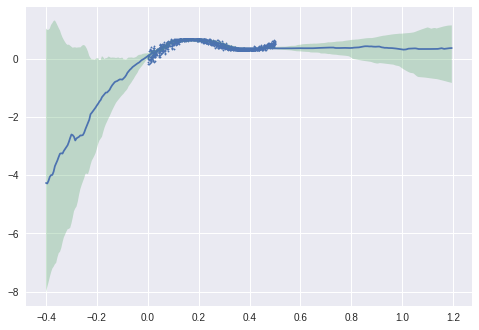

loss: tensor(650.6836, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(656.3498, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.6662, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(652.8965, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(657.7479, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.8514, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(630.5418, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(635.5740, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.0322, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(636.1494, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(639.3865, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.2372, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(631.5317, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(626.1024, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(5.4294, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(622.2717, device='cuda:0', grad_fn=<AddBackward0

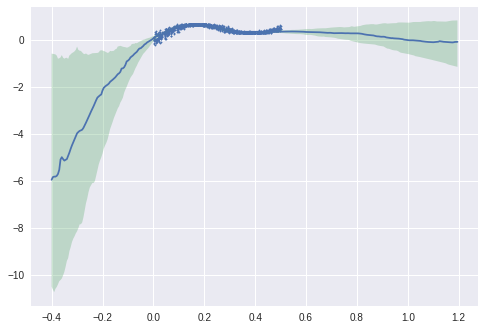

loss: tensor(601.2950, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(599.3693, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(1.9256, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(584.8463, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(590.6948, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.8485, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(591.2310, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(595.9854, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.7544, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(570.3154, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(575.6594, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.3439, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(563.4528, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(568.1276, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.6748, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(558.3582, device='cuda:0', grad_fn=<AddBackward0

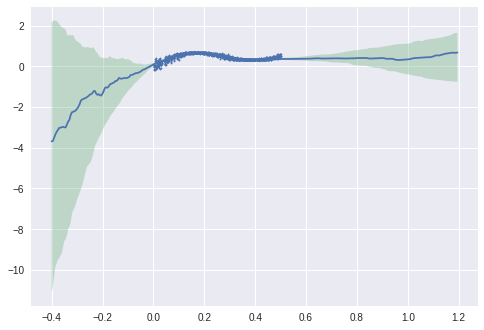

loss: tensor(541.7336, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(547.7615, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.0280, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(539.9774, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(542.4680, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-2.4906, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(532.0942, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(536.5779, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.4837, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(523.8527, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(530.0586, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.2059, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(523.0338, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(527.2734, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.2397, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(519.8014, device='cuda:0', grad_fn=<AddBackward

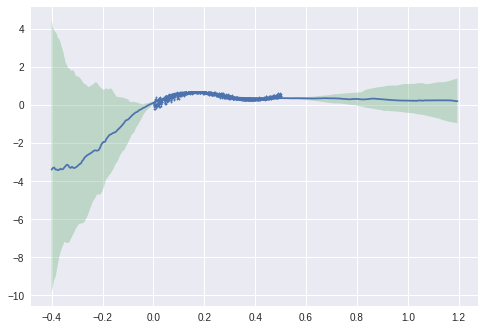

loss: tensor(488.9534, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(494.1820, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.2287, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(476.7967, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(480.7104, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.9136, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(476.6117, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(481.0662, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.4546, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(466.8377, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(471.4395, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.6017, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(472.9232, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(477.3680, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.4447, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(473.4280, device='cuda:0', grad_fn=<AddBackward

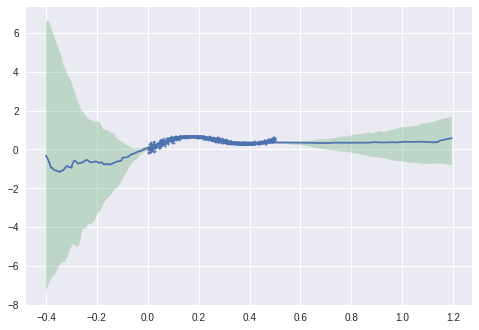

loss: tensor(450.4241, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(454.3373, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.9132, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(440.4328, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(446.0237, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.5908, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(440.3436, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(445.7201, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.3765, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(430.4166, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(435.3065, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.8899, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(429.9297, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(431.8820, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-1.9523, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(424.7747, device='cuda:0', grad_fn=<AddBackward

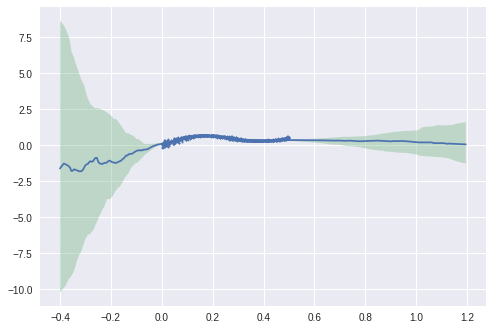

loss: tensor(412.8077, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(419.0070, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.1994, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(397.5247, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(403.5668, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.0421, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(403.7863, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(408.0229, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.2365, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(407.0500, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(404.8424, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(2.2076, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(399.2230, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(402.3764, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.1534, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(387.7974, device='cuda:0', grad_fn=<AddBackward0

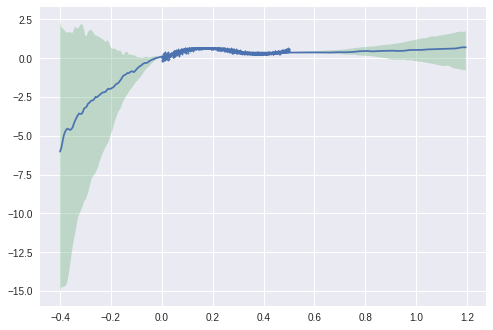

loss: tensor(365.0372, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(371.4937, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.4565, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(361.6724, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(367.4273, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.7549, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(360.0678, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(365.8809, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.8131, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(365.6198, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(369.6053, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-3.9855, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(354.1828, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(361.2314, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-7.0486, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(351.8592, device='cuda:0', grad_fn=<AddBackward

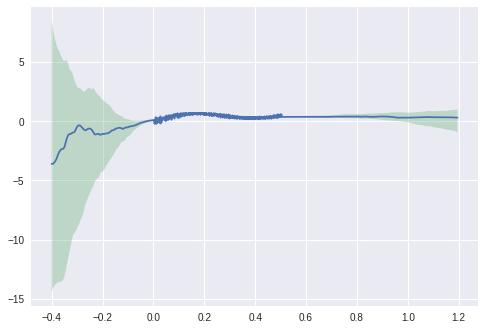

loss: tensor(339.3192, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(345.4666, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.1474, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(330.3480, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(337.0930, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.7450, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(335.5601, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(335.9723, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.4122, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(334.3805, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(339.4365, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.0561, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(554.4393, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(328.3471, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(226.0922, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(328.1511, device='cuda:0', grad_fn=<AddBackwar

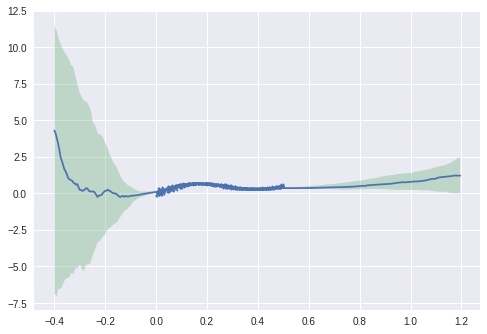

loss: tensor(307.1744, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(312.3887, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.2142, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(304.9317, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(311.5330, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-6.6013, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(302.7838, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(303.6342, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-0.8503, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(292.0175, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(297.0396, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.0221, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(288.2063, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(293.3906, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.1844, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(288.6702, device='cuda:0', grad_fn=<AddBackward

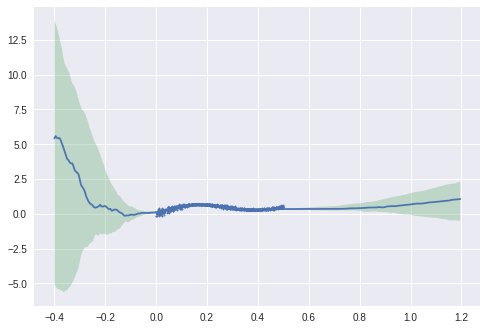

loss: tensor(281.7107, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(286.5893, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.8785, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(273.6436, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(277.8889, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.2453, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(274.6314, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(280.2617, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.6303, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(262.2514, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(267.6447, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-5.3933, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(254.9613, device='cuda:0', grad_fn=<AddBackward0>)
kl: tensor(259.7756, device='cuda:0', grad_fn=<MulBackward0>)
nll: tensor(-4.8143, device='cuda:0', grad_fn=<DivBackward0>)
loss: tensor(257.4598, device='cuda:0', grad_fn=<AddBackward

KeyboardInterrupt: ignored

In [32]:
# Training

optimizer = optim.Adam(net.parameters(), lr=0.003)
net.train()

for epoch in range(30001):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        num_batches = len(trainloader)
        # forward + backward + optimize
        loss, kl, nll = net.cost_function(inputs, labels, num_samples=10, ratio=1/num_batches)
        if i % 100 == 0:
          print("loss:", loss)
          print("kl:", kl)
          print("nll:", nll)
        loss.backward()
        optimizer.step()
    
    if(epoch%10==0):
        net.train()
        outputs = []
        for sample_count in range(100):
          outputs.append(net(true_range.view([320, 1])))
        outputs = torch.cat(outputs, dim=1).detach().cpu().numpy()
        output_median = np.median(outputs, axis=1)
        output_lower = np.percentile(outputs, 25, axis=1)
        output_higher = np.percentile(outputs, 75, axis=1)
        plt.plot(true_range.flatten().cpu().numpy(), output_median)
        plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy(),s = 2)
        plt.fill_between(true_range.flatten().cpu().numpy(), output_lower, output_higher, interpolate=True, alpha=0.3)
        plt.plot()
        plt.show()

print('Finished Training')

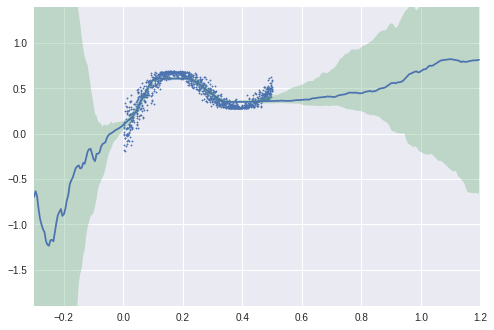

In [46]:
# generate the plot
net.train()
outputs = []
for sample_count in range(100):
  outputs.append(net(true_range.view([320, 1])))
outputs = torch.cat(outputs, dim=1).detach().cpu().numpy()
output_median = np.median(outputs, axis=1)
output_lower = np.percentile(outputs, 25, axis=1)
output_higher = np.percentile(outputs, 75, axis=1)
plt.plot(true_range.flatten().cpu().numpy(), output_median)
plt.scatter(trainfeatures.flatten().cpu().numpy(), trainlabels.flatten().cpu().numpy(),s = 2)
plt.fill_between(true_range.flatten().cpu().numpy(), output_lower, output_higher, interpolate=True, alpha=0.3)
plt.ylim(-1.9,1.4)
plt.xlim(-0.3, 1.2)
plt.plot()
plt.show()